In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from rubin_sim.data import get_baseline
import rubin_sim.maf as maf
import sqlite3
import pandas as pd
import os

In [2]:
#baseline_file = get_baseline()
#baseline_file = '/Users/yoachim/runs31/ender/ender_a1_v3.1_10yrs.db'
baseline_file = '/Users/yoachim/runs32/near_sun/near_sun_fdw_3.00_v3.2_10yrs.db'

#baseline_file = '/Users/yoachim/runs32/ddf_loaded/ddf_loaded_fl4_v3.2_10yrs.db'


run_name = os.path.basename(baseline_file.replace('.db', ''))

In [3]:
sqls = {'note like "DD%%"': 'DDFs', 'note ="greedy"': 'greedy', 'note like "blob,%"': 'blobs',
        'note like "blob_twi%"': 'blobs twilight', 'note like "twilight_neo%"': 'twilight NEO',
       'note ="long"': 'long', 'note like "blob_long%"': 'long start', '': 'Everything',
       'note like "%near_sun%"': 'near sun', 'note like "pair_33%"': 'pair 33', 'note like "pair_15%"': 'pair 15'}

In [4]:
bundle_list = []
ra_plots = [maf.plots.HealpixSkyMap()]
aa_plots = [maf.plots.LambertSkyMap()]
for sql in sqls:
    slicer = maf.HealpixSlicer()
    metric = maf.CountMetric(col='night', units='#', metric_name=sqls[sql])
    
    bundle_list.append(maf.MetricBundle(metric, slicer, sql, plot_funcs=ra_plots,run_name=run_name))
    
    slicer = maf.HealpixSlicer(lat_col='altitude', lon_col='azimuth')
    metric = maf.CountMetric(col='night', units='#', metric_name=sqls[sql]+' alt/az')
    bundle_list.append(maf.MetricBundle(metric, slicer, sql, plot_funcs=aa_plots,run_name=run_name))
    
    slicer = maf.UniSlicer()
    metric = maf.SumMetric(col="visitExposureTime")
    summary = [maf.PassMetric()]
    bundle_list.append(maf.MetricBundle(metric, slicer, sql, summary_metrics=summary,run_name=run_name))
    
    slicer = maf.HourglassSlicer()
    metric = maf.HourglassMetric()
    
    extra = ' and '
    if sql == '':
        extra = ''
    
    bundle = maf.MetricBundle(
            metric,
            slicer,
            sql + extra + ' night < 366',run_name=run_name
        )
    bundle_list.append(bundle)
    
    

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slic

        Use get_body("moon") instead. [rubin_sim.maf.metrics.hourglass_metric]
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/metric_bundles/metric_bundle_group.py:282: UserWarning: No data matching constraint note like "twilight_neo%" and  night < 366
  warnings.warn("No data matching constraint %s" % constraint)
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/metric_bundles/metric_bundle_group.py:288: UserWarning:  This means skipping metrics ['Hourglass observationStartMJD, filter, night : note like twilight_neo% and night < 366 : HourglassSlicer']
  warnings.warn(" This means skipping metrics %s" % metrics_skipped)
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/metric_bundles/metric_bundle_group.py:282: UserWarning: No data matching constraint note like "blob_twi%" and  night < 366
  warnings.warn("No data matching constraint %s" % constraint)
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/metric_bundles/metric_bundle_group.py:288: UserWarning:  This means skipping metrics [

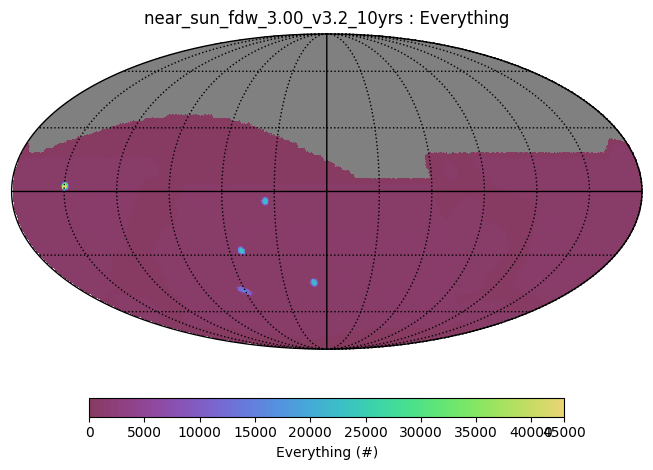

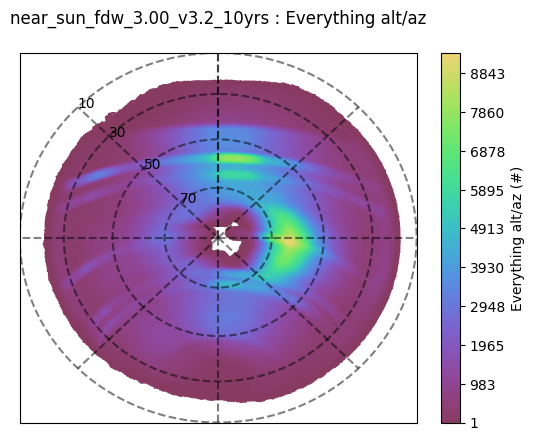

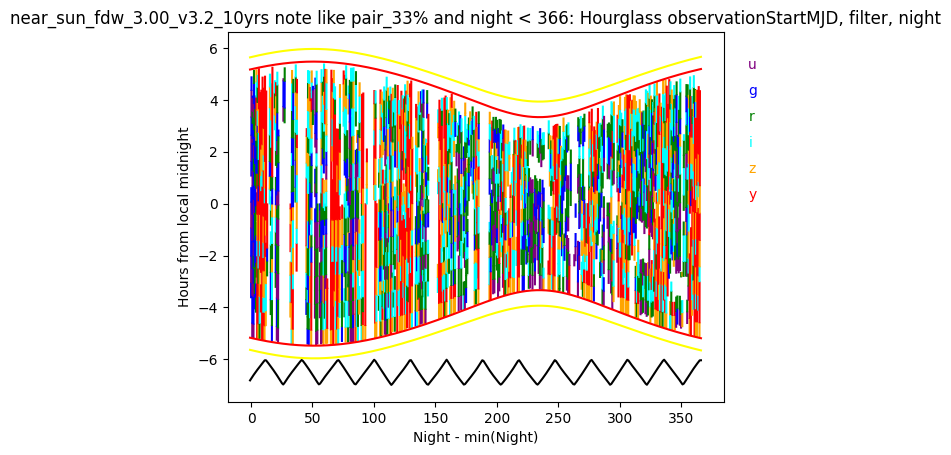

<Figure size 640x480 with 0 Axes>

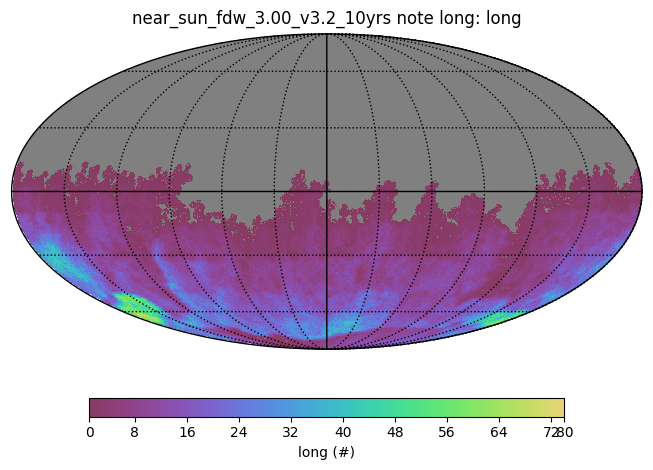

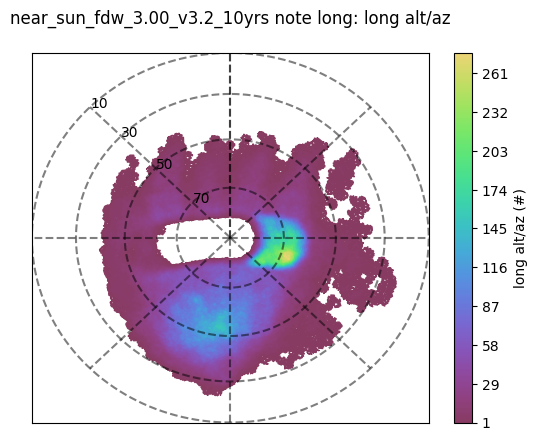

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

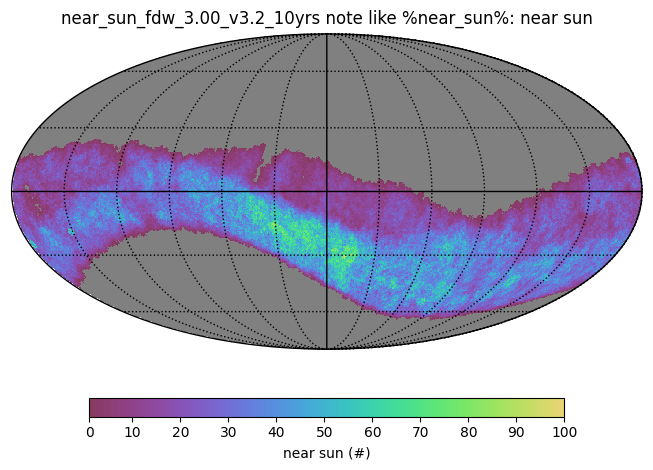

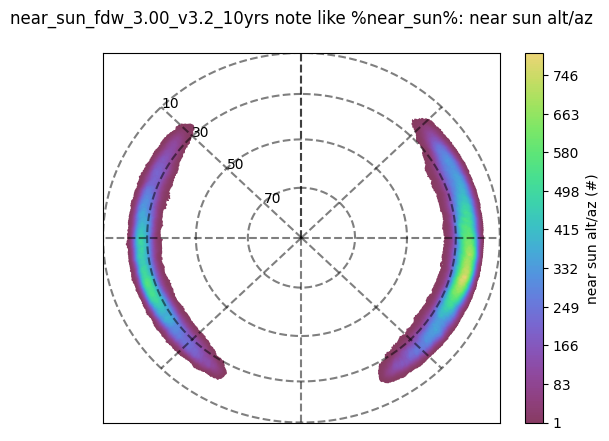

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

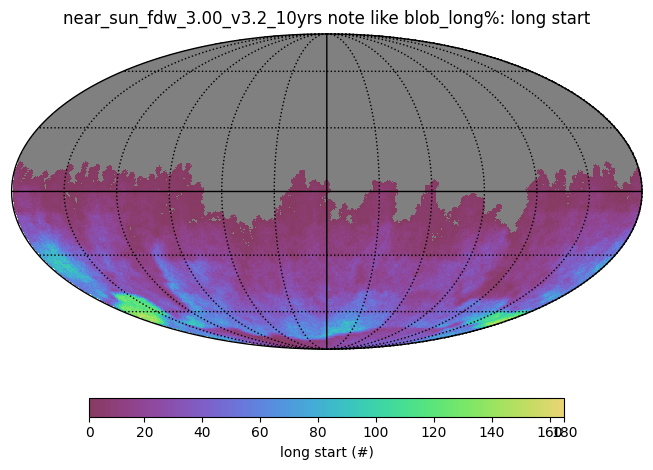

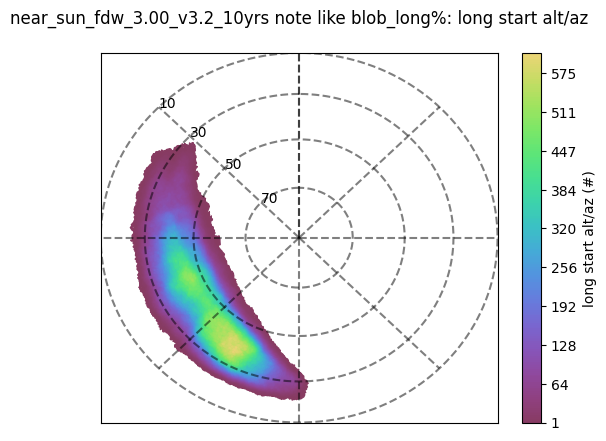

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

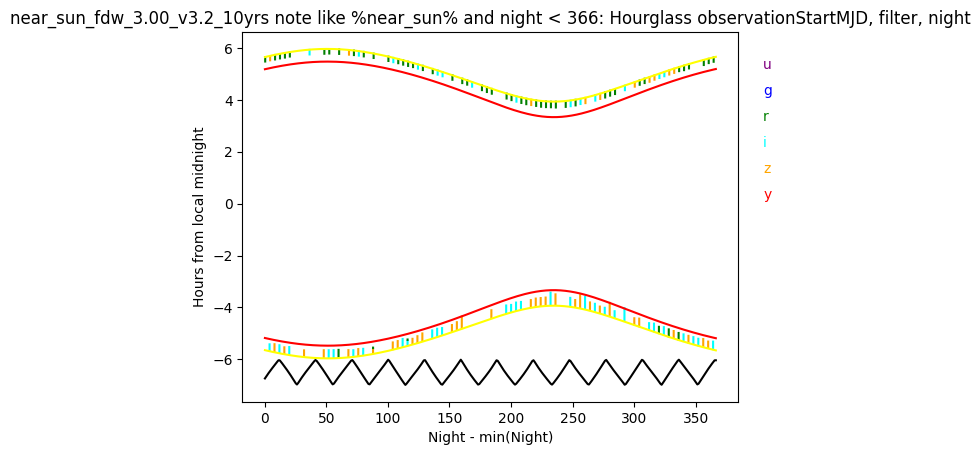

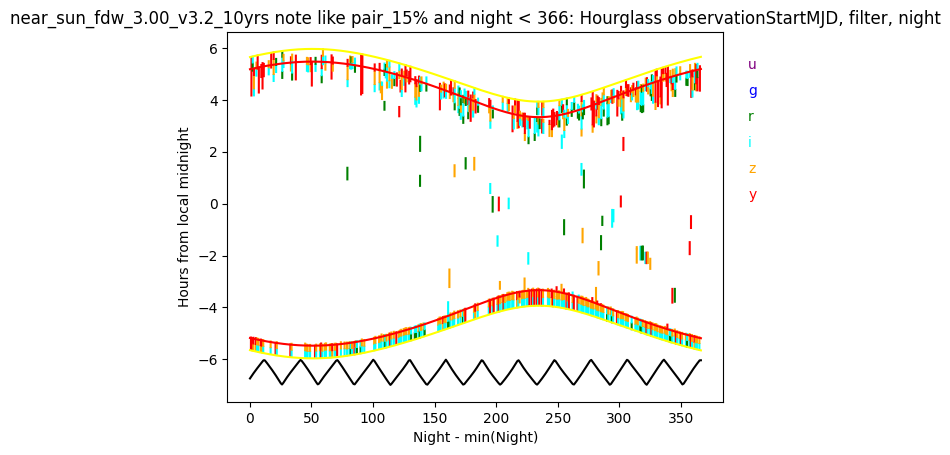

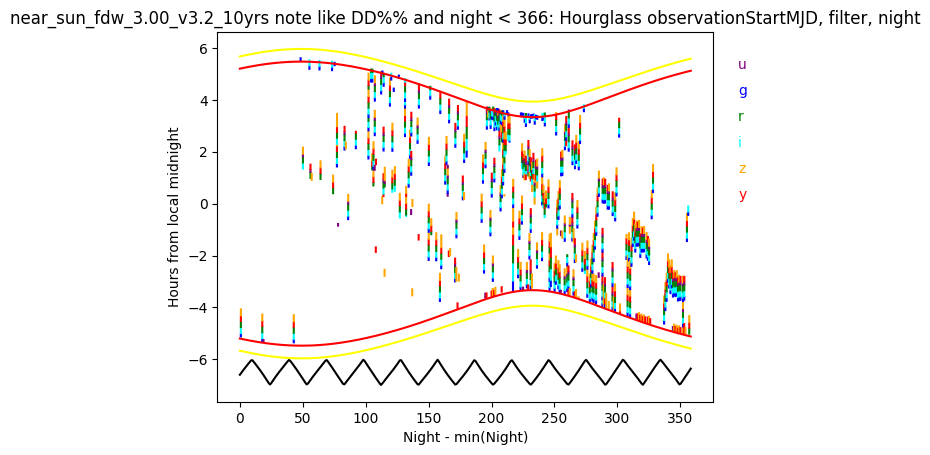

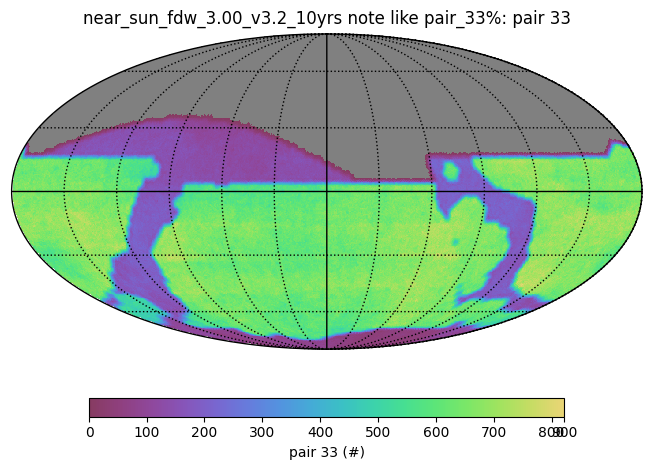

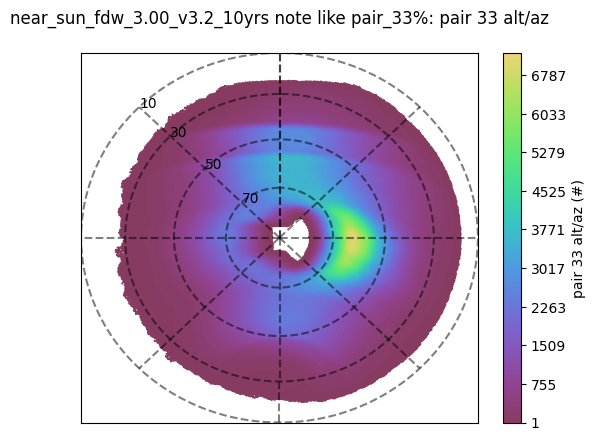

<Figure size 640x480 with 0 Axes>

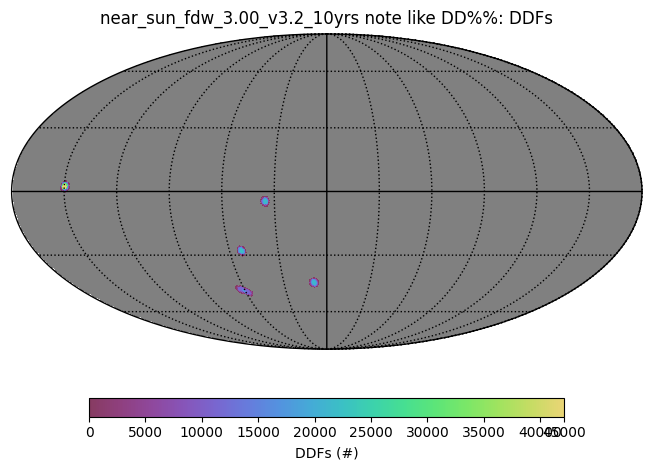

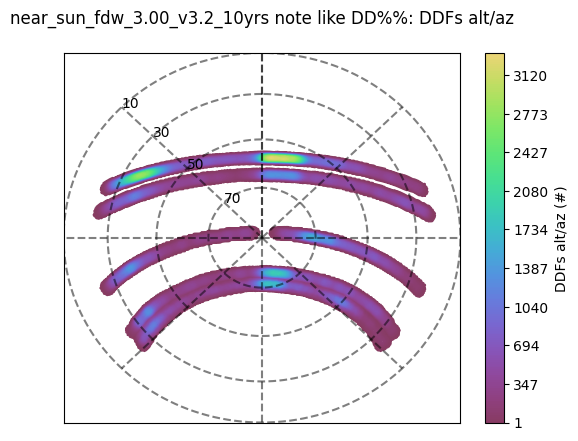

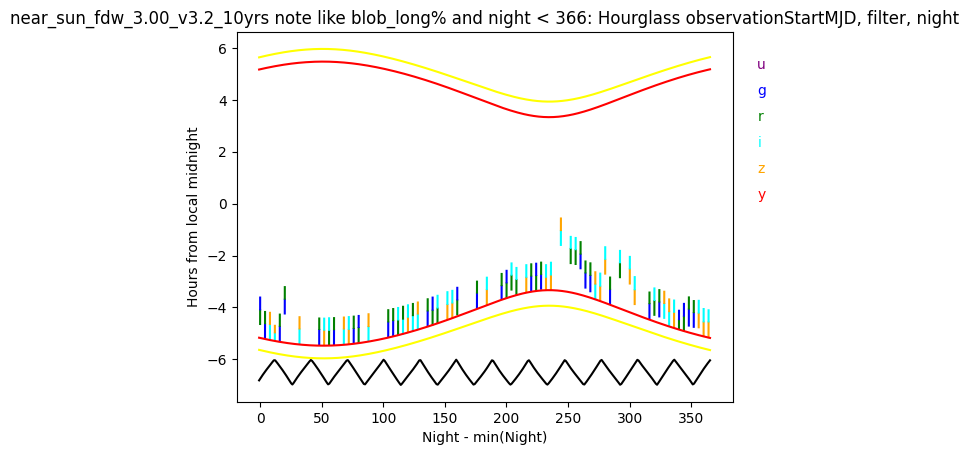

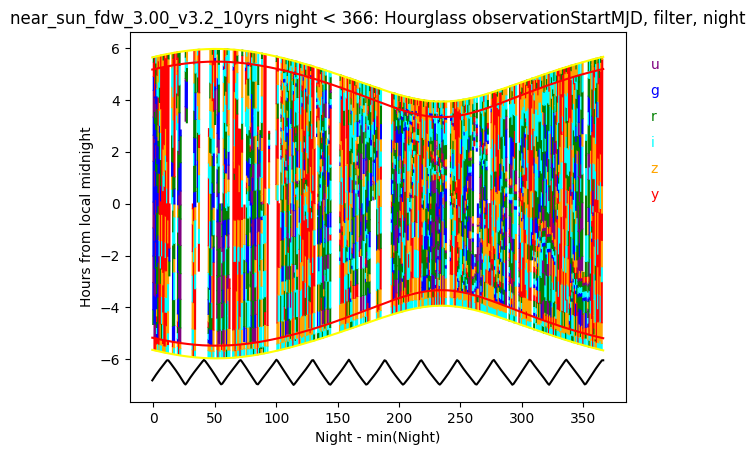

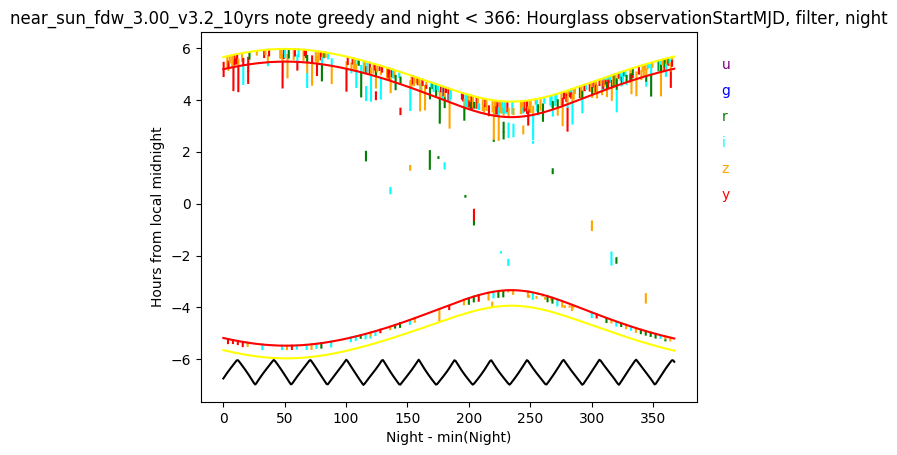

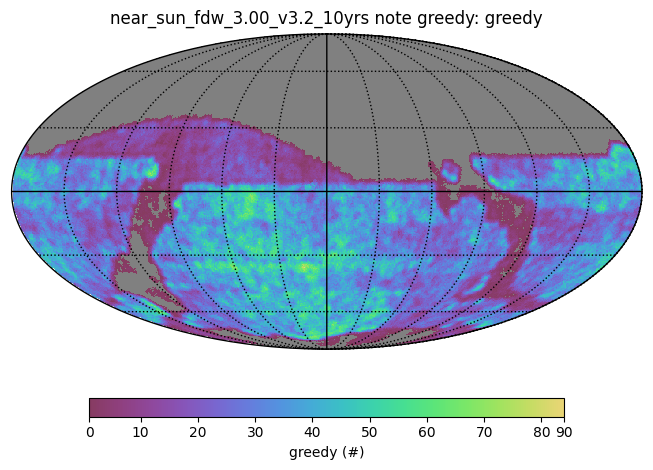

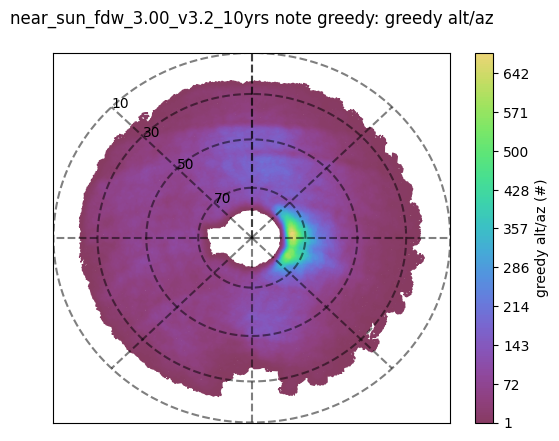

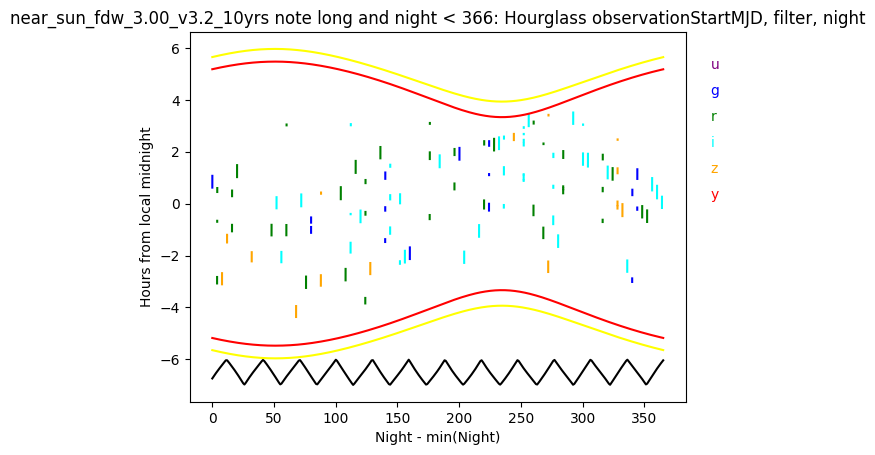

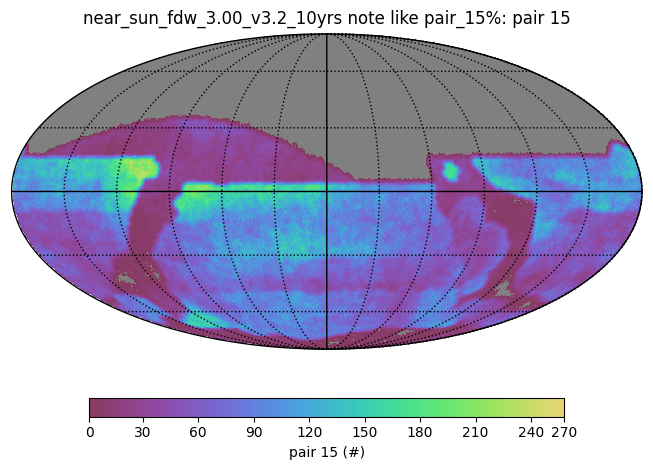

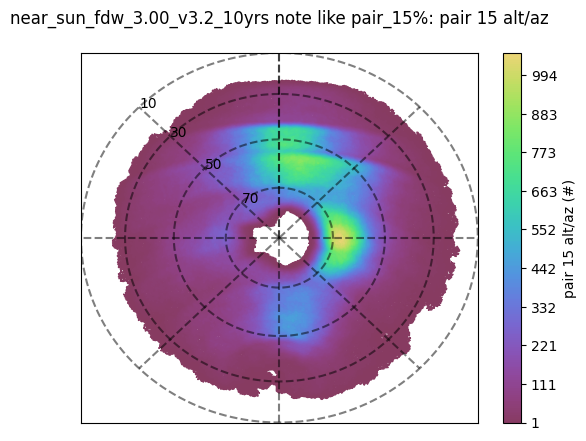

In [5]:
bd = maf.make_bundles_dict_from_list(bundle_list)
mbg = maf.MetricBundleGroup(bd, baseline_file, 'temp')
mbg.run_all()
mbg.plot_all(closefigs=False)

In [6]:
total = 0

for m in bundle_list:
    if m.constraint == '':
        if len(m.summary_values) > 0:
            total = np.max(m.summary_values['Pass '][0][0])
            

for m in bundle_list:
    if m.summary_values is not None:
        if len(m.summary_values) > 0:
            print(m.constraint, m.summary_values['Pass '][0][0],  "%.1f%%" % (m.summary_values['Pass '][0][0]/total*100))

note like "DD%%" 4241010.0 6.7%
note ="greedy" 2459520.0 3.9%
note ="long" 706980.0 1.1%
note like "blob_long%" 1690140.0 2.7%
 62862480.0 100.0%
note like "%near_sun%" 781260.0 1.2%
note like "pair_33%" 46596180.0 74.1%
note like "pair_15%" 6387390.0 10.2%


In [7]:
# let's loop over and figure out how often each type executes

con = sqlite3.connect(baseline_file)
n_un = []


exptime = []

for sql in sqls:
    if sql == '':
        val = pd.read_sql('select count(distinct(night)) from observations  ;', con)
        exp = pd.read_sql('select sum(visitExposureTime) from observations  ;', con)
    else:
        val = pd.read_sql('select count(distinct(night)) from observations where ' + sql + ' ;', con)
        exp = pd.read_sql('select sum(visitExposureTime) from observations where ' + sql + ' ;', con)
    n_un.append(np.max(val))
    exptime.append(np.max(exp))

In [8]:
n_un

[1500, 2206, 0, 0, 0, 581, 619, 2809, 683, 2790, 2054]

In [9]:
exptime

[4241010.0,
 2459520.0,
 nan,
 nan,
 nan,
 706980.0,
 1690140.0,
 62862480.0,
 781260.0,
 46596180.0,
 6387390.0]

In [10]:
sqls

{'note like "DD%%"': 'DDFs',
 'note ="greedy"': 'greedy',
 'note like "blob,%"': 'blobs',
 'note like "blob_twi%"': 'blobs twilight',
 'note like "twilight_neo%"': 'twilight NEO',
 'note ="long"': 'long',
 'note like "blob_long%"': 'long start',
 '': 'Everything',
 'note like "%near_sun%"': 'near sun',
 'note like "pair_33%"': 'pair 33',
 'note like "pair_15%"': 'pair 15'}

In [11]:
for sql, expt in zip(sqls, exptime):
    print(sql, expt/np.nanmax(exptime))

note like "DD%%" 0.06746488525428841
note ="greedy" 0.039125405170142825
note like "blob,%" nan
note like "blob_twi%" nan
note like "twilight_neo%" nan
note ="long" 0.011246454164710014
note like "blob_long%" 0.026886308017119272
 1.0
note like "%near_sun%" 0.012428081106567861
note like "pair_33%" 0.741239925628133
note like "pair_15%" 0.10160894065903858


In [12]:
sql_base = 'note like "DD%%" and '
bundle_list = []
ra_plots = [maf.plots.HealpixSkyMap()]
aa_plots = [maf.plots.LambertSkyMap()]
nights = np.arange(11)*365.25
for n1,n2 in zip(nights[0:-1], nights[1:]):
    sql = sql_base + 'night > %i and night < %i' % (n1,n2)
    
    slicer = maf.HourglassSlicer()
    metric = maf.HourglassMetric()
    
    
    bundle = maf.MetricBundle(
            metric,
            slicer,
            sql,run_name=run_name
        )
    bundle_list.append(bundle)
    

/Users/yoachim/anaconda3/envs/rubin2/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 713 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/rubin2/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 106950 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/rubin2/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 106950 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/rubin2/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 358 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/rubin2/lib/python3.11/site-packages/

/Users/yoachim/anaconda3/envs/rubin2/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 36300 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/rubin2/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 242 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/rubin2/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 729 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/rubin2/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 109350 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/rubin2/lib/python3.11/site-packages/e

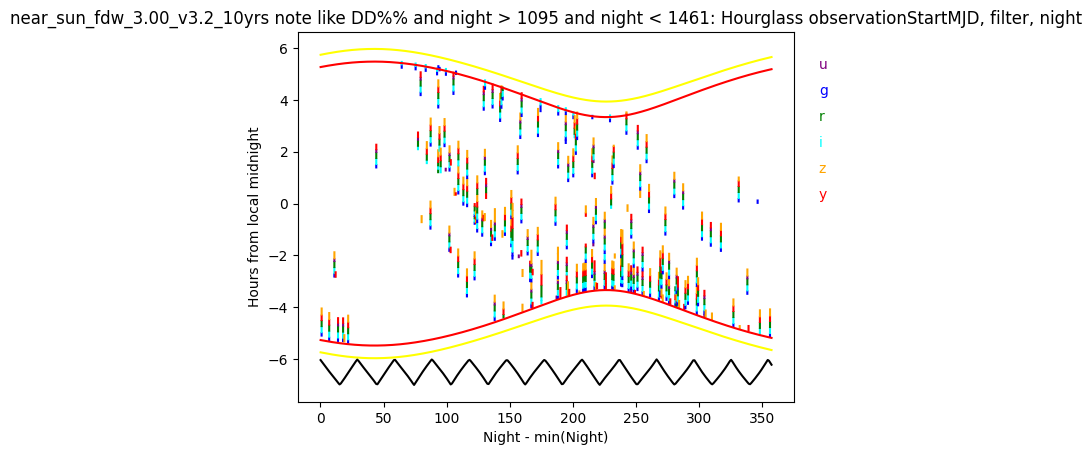

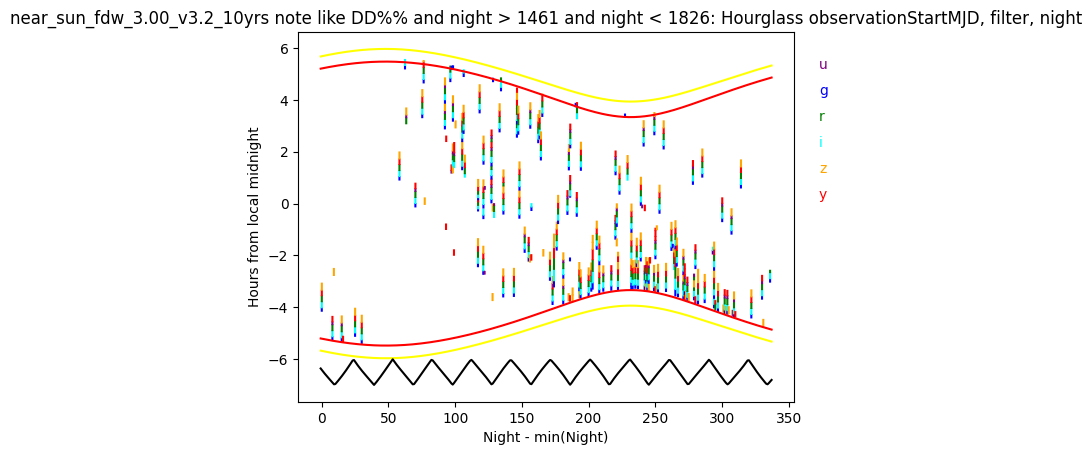

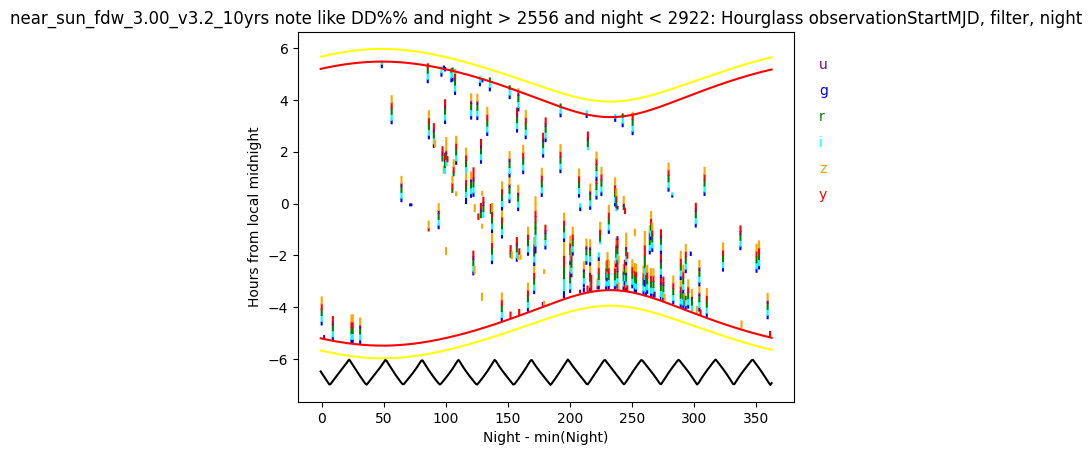

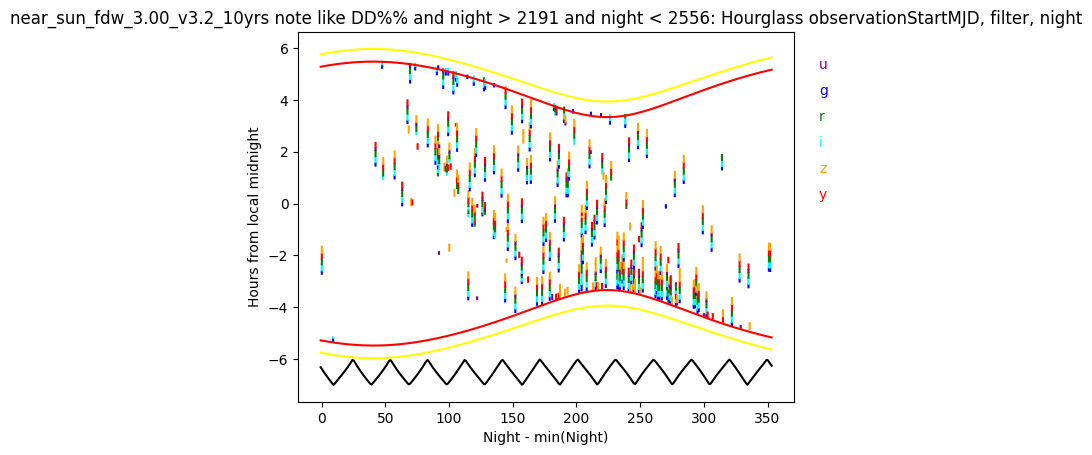

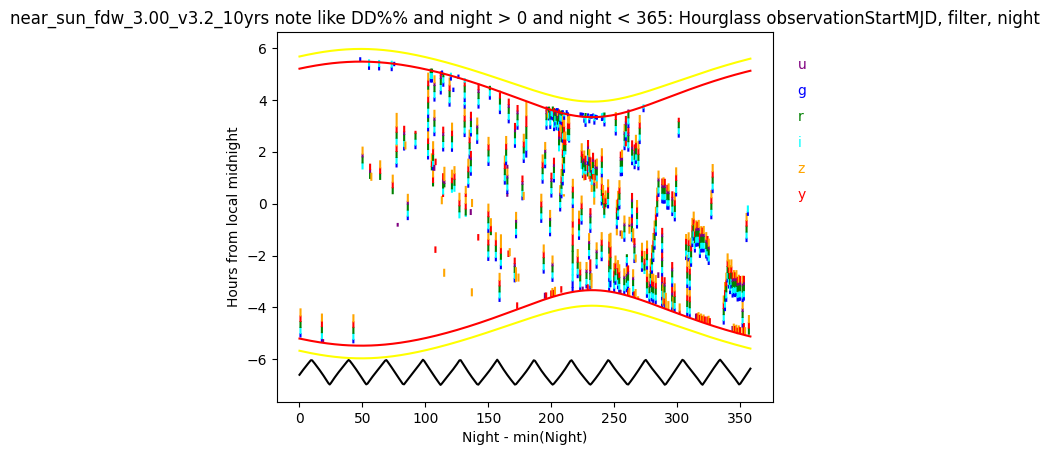

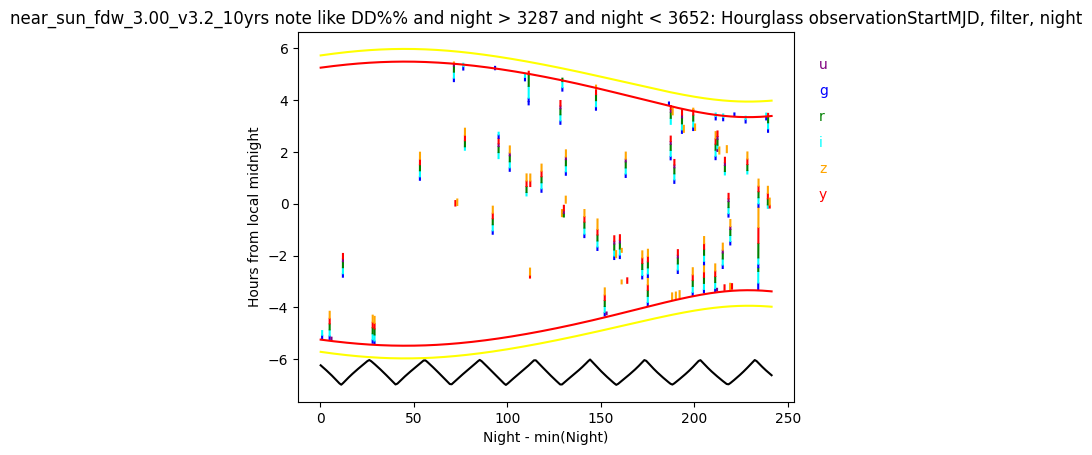

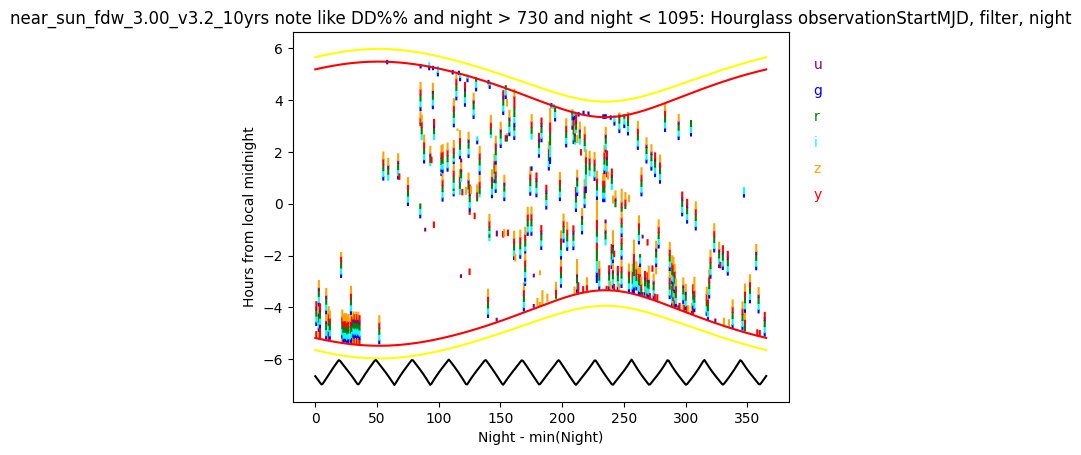

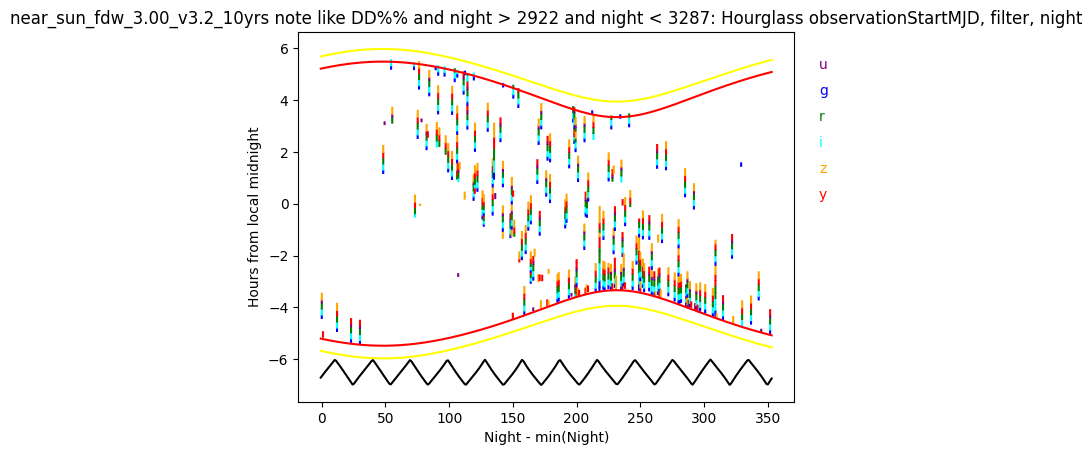

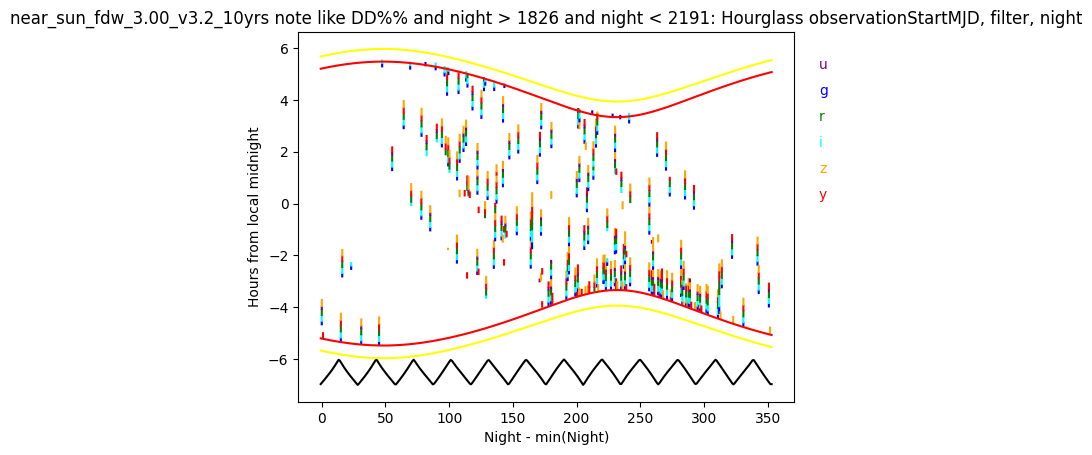

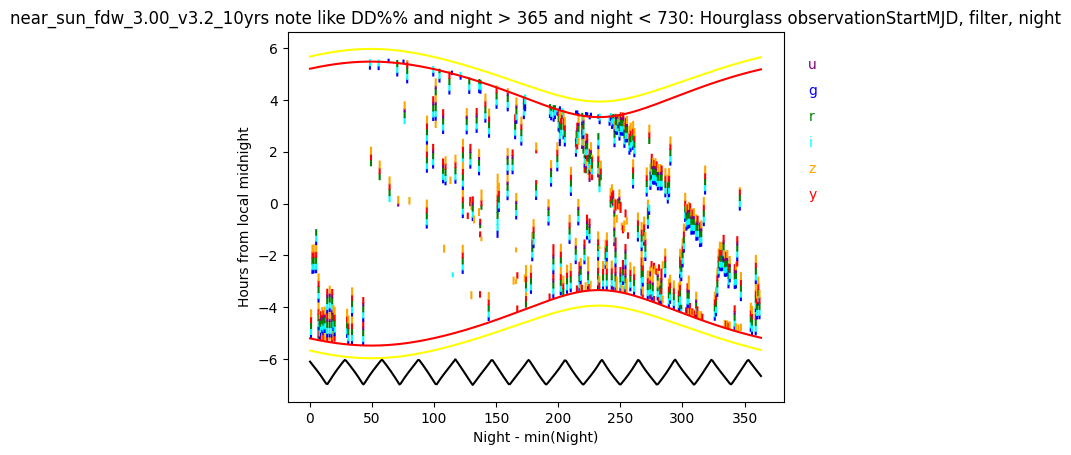

In [13]:
bd = maf.make_bundles_dict_from_list(bundle_list)
mbg = maf.MetricBundleGroup(bd, baseline_file, 'temp')
mbg.run_all()
mbg.plot_all(closefigs=False)